# Гипотезы и А/В-тест для интернет-магазина

В крупном интернет-магазине появился запрос на аналитику. Отделы маркетинга и аналитики подготовили список гипотез для увеличения выручки. Нужно приоритизировать гипотезы и проанализировать результаты уже проведенного А/В теста

###### Цель работы

1. Приоретизировать гипотезы
2. Проанализировать результат А/В теста и вынести решение относительно его продолжения 

###### План работы

1. Общая информация
2. Предобработка данных
3. Приоритезация гипотез
4. Анализ А/В теста: 
 - Создание сводной таблицы с кумулятивными показателями
 - Визуализация ключевых метрик
 - Определение аномалий
 - Сравнение статистической значимости по сырым и отфильтрованным данным 
 - Вывод
5. Выводы по проекту

## Общая информация

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt 
import scipy.stats as stats
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#выведем первые строки датасетов и информацию о таблицах
hypothesis = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/hypothesis.csv')
visitors = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/visitors.csv')
orders = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/orders.csv')


display(hypothesis)
display(hypothesis.info())

display(visitors.head())
display(visitors.info())
display(orders.head())
orders.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Для первой части работы нам потребуются данные по гипотезам, которые сохранены в таблице hypothesis. Всего дано 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами (Reach, Impact, Confidence, Effort), распределенными по столбцам. Параметры оценены по десятибальной шкале.
Типы данных корректы - для описания используется object, для и оцеки по шкалам int64. Дубликатов, пропусков и нулевых значени нет, что видно невооруженным глазом. В названиях присутсвуют заглавные буквы 

Для второй части есть данные по А/В-тесту, которые хранятся в 2х таблицах: orders и visitors. В таблице orders следующие столбцы:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

В таблице visitors:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [3]:
display(visitors['date'].max())
visitors['date'].min()

'2019-08-31'

'2019-08-01'

In [4]:
display(visitors['date'].max())
visitors['date'].min()

'2019-08-31'

'2019-08-01'

Временные рамки обоих таблиц совпадают и видно, что А/B тест продолжался с 1-го по 31-ое августа 2019 года. За это время было сделано 1197 заказов. Проверим не получилось ли так, что один и тот же пользователь попал в разнве группы 

In [5]:
group_a = orders.query('group == "A"')
group_b = orders.query('group == "B"')

#group_a

In [6]:
flickers_check = [x for x in list(group_b['visitorId']) if x in list(group_a['visitorId'])]

print('Количество пользователе, которые попали в обе группы: ', 
        len(set(flickers_check)))

Количество пользователе, которые попали в обе группы:  58


In [7]:
#list(set(flickers_check))
orders.query('visitorId == 3957174400')

,transactionId,visitorId,date,revenue,group
269,1067267410,3957174400,2019-08-18,2480,A
561,3241914033,3957174400,2019-08-26,2480,B


In [8]:
print('Процент пользователей, попавших в обе группы: {:.1%}'.format(
            len(set(flickers_check)) / len(orders['visitorId'].unique())
            ))

Процент пользователей, попавших в обе группы: 5.6%


В таблицу попало 58 пользователей, которые по какой-то причине попали в две группы одновременно, при этом таких пользователей около 5%. Возможно, так получилось потому, что пользователь заходил с двух разных устройств или если даты совпадают то пользователь мог провести часть времени на одной верии сайта, а потом оказаться на другой. Возможно, стоит проверить как работает разделение пользователей на группы и посмотреть нет ли там технических неполадок. В любом случае, такие пользователи могут оказать влияние на результат теста и стоит их исключить из анализа

In [9]:
flickers_check = list(set(flickers_check))
orders = orders.query('visitorId != @flickers_check')

###### Вывод

В обоих таблицах нет пропусков и мы отобрали лишь тех пользователей, которые попадают строго в одну группу. Типы данных по id, доходам и группам пригодны для работы (хотя стоит заметить, что id закодированы типом int64), однако в обоих таблицах есть указания дат, которые необходиом привести к типу datetime. Также можно приветси названия таблиц к едниному виду, так как сейчас некторые из них содержат большие буквы

## Предобработка

In [10]:
#изменим тип данных у дат
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'],format='%Y-%m-%d')


In [11]:
#проверим на дубликаты 
print("Колличество дубликатов в таблице orders:", orders.duplicated().sum())
print("Колличество дубликатов в таблице visitors:", visitors.duplicated().sum())

Колличество дубликатов в таблице orders: 0
Колличество дубликатов в таблице visitors: 0


In [12]:
display(hypothesis.columns)
orders.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [13]:
#приведем все колонки к одному виду
hypothesis.columns = [name.lower() for name in hypothesis.columns]
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Названия всех столбцов выглядят одинаково и данные, котрые нам нужны для работы, приведены к корректным типам - можно приступать к анализу 

## Приоритезация гипотез 

In [14]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


In [15]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Не так важно какие именно цифры мы получили после применения фреймворков, а важно именно место гипотез среди остальных. По фреймврорку ICE приоритет отдается гипотезам про скидку на день рождение,про привлечение новых каналов трафика и про сбор базы для email-рассылки. 

По феймворку RICE - лидирует гипотеза про базу для email рассылки, вместе с ней гипотеза про реккомедации и новые каналы трафика. 

Так получилось потому что модифкация RICE учитывает то, скольких пльзователей затронет нововведение. Так, самая перспективная по ICE гипотеза про акцию на день рождения затронет очень мало пользователей - ведь эта скидка актуальна только для тех, кто будет что-то покупать в свой день рождения. Однако судя по другим параметрам можно уверенно утверждать, что это не самое трудоемкое нововведение повлияет довольно сильно на пользователей. Поэтому стоит уточнить у заказчика какие зоны роста его интересуют - эту гипотезу имеет смысл тестировать, если заказчик, например, хочет выделиться среди конкурентов. Сравнимые параметры есть у гипотезы по привлечению новых каналов тарфика - она также подействует не на много людей, но подействет сильно. Но к ее тестированию следует обращаться, если заказчик нацелен на привлечение новых пользователей. 

Гипотеза про сбор базы для email-рассылки, самая приорететная по RICE и одна из приоритетных по ICE, довольно сильно затронет всех пользователей. Если заказчик, хочет улучшать метрики, связанные сразу со всеми ползователями (например, повышать конверсию или сохранять текущих пользователей), то имеет смысл тестрировать эту гипотезу и/или гипотезу про добаление рекомендаций - она тоже затронет довольно много пользователей, но не так сильно, к тому же она легче в исполнении. 

In [16]:
pd.options.display.max_colwidth = 120

cm = sns.light_palette("orange", as_cmap=True)

hypothesis.sort_values(by='RICE', ascending=False).style.background_gradient(cmap=cm)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


###### Вывод

Приоритезация гипотез показала, что разные гипотезы могут быть в приоритете, исходя из примененного метода. Однако также важно ориентироваться на то, что необходимо получить на выходе. Например, если нужно прилекать новых пользователей, то стоит проверят гипотезу про сбор данных для email-рассылки или гипотезу про привлечение новых каналов трафика. А если цель - повышение конверсии, то стоит проверить гипотезы о добавлении на сайт рекомендаций или баннеров с акциями

## Анализ A/B-теста

### Создание сводной таблицы для построения графиков 

In [17]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

Сплит в группах А и В сделан примерно 50/50. Создадаим одну сводную таблицу, в которой будут посчитаны колличесво поситтелей, количесво заказав и сумма заказов по группам. Также добавим в эту таблицу кумулятивные версии этих показателей

In [18]:
#создадим таблицы для каждой группы, где будет указано количество посетителей за каждую дату
visitors_a_daily = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_a_per_date']
display(visitors_a_daily.head())

visitors_b_daily = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_b_per_date']
visitors_b_daily.head()

,date,visitors_a_per_date
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitors_b_per_date
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [19]:
#сделаем куммулятивные версии этих таблиц
#теперь в каждой строке есть дата и сумма всех пользователей за эту дату + сумма ползователей за все предыдущие даты

visitors_a_cum = visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_a_per_date': 'sum'}),
    axis=1,
)
visitors_a_cum.columns = ['date', 'visitors_a_cum']
display(visitors_a_cum.head())

visitors_b_cum = visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_b_per_date': 'sum'}),
    axis=1,
)
visitors_b_cum.columns = ['date', 'visitors_b_cum']
visitors_b_cum.head()


,date,visitors_a_cum
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


,date,visitors_b_cum
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [20]:
#сделаем тоже самое для заказов - будем считать колличесвто заказов и сумму выручки с них 
orders_a = orders.query('group == "A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
orders_a_daily = (orders_a
                  .groupby('date', as_index=False)
                  .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_a_daily.columns = ['date', 'orders_a_per_date', 'revenue_a_per_date']
display(orders_a_daily.head())

orders_b = orders.query('group == "B"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
orders_b_daily = (orders_b
                  .groupby('date', as_index=False)
                  .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_b_daily.columns = ['date', 'orders_b_per_date', 'revenue_b_per_date']
orders_b_daily.head()


,date,orders_a_per_date,revenue_a_per_date
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


,date,orders_b_per_date,revenue_b_per_date
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [21]:
#куммулятивные версии таблиц с заказами

orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'orders_a_per_date': 'sum', 'revenue_a_per_date': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cum.columns = ['date','orders_a_cum','revenue_a_cum']


orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
    .agg({'date': 'max', 'orders_b_per_date': 'sum', 'revenue_b_per_date': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cum.columns = ['date','orders_b_cum','revenue_b_cum']

display(orders_a_cum.head())
orders_b_cum.head()

,date,orders_a_cum,revenue_a_cum
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


,date,orders_b_cum,revenue_b_cum
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [22]:
#склеиваем все в одну таблицу 
data = (
    orders_a_daily.merge(orders_b_daily, on='date', how='left')
    .merge(orders_a_cum, on='date', how='left')
    .merge(orders_b_cum, on='date', how='left')
    
    .merge(visitors_a_daily, on='date', how='left')
    .merge(visitors_b_daily, on='date', how='left')
    .merge(visitors_a_cum, on='date', how='left')
    .merge(visitors_b_cum, on='date', how='left')
)
data.head()

,date,orders_a_per_date,revenue_a_per_date,orders_b_per_date,revenue_b_per_date,orders_a_cum,revenue_a_cum,orders_b_cum,revenue_b_cum,visitors_a_per_date,visitors_b_per_date,visitors_a_cum,visitors_b_cum
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Мы получили таблицу, где каждая строка соотвествует одному дню проведения теста. В строке указано количесво посетителей, количесвто заказов и общая сумма этих заказов для каждой группыю. Тажке все эти метрики присутсвуют и в кумудятивной версии. 

### Визуализация ключевых метрик

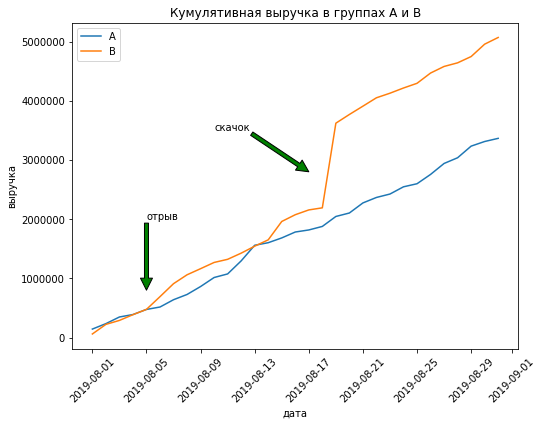

In [23]:
#график кумулятивной выручки

plt.figure(figsize=(8,6))
plt.plot(data['date'], data['revenue_a_cum'], label='A')
plt.plot(data['date'], data['revenue_b_cum'],  label='B')

plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))

plt.legend() 
plt.title('Кумулятивная выручка в группах А и В')
plt.xlabel('дата')
plt.ylabel('выручка')
plt.xticks(rotation=45) 
plt.show()


  

После небольшого периода, когда разницы в выручке не было, группа В начала немного выраваться вперед. По истечении примерно 2х недель группа А ее догнала, однако вскоре группа В сильно вышла вперед - это может сигнализировать о появлении очень дорогих заказов в выборке. Чуть позже посмотрим на выбросы, а пока построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

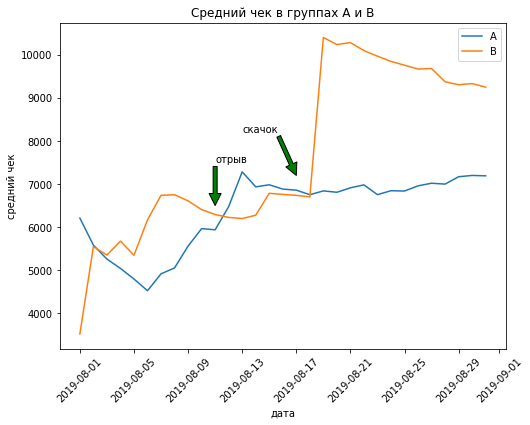

In [24]:
plt.figure(figsize=(8,6))
plt.plot(data['date'], data['revenue_a_cum']/data['orders_a_cum'], label='A')
plt.plot(data['date'], data['revenue_b_cum']/data['orders_b_cum'], label='B')

plt.annotate('отрыв', xy=('2019-08-11', 6500), xytext=('2019-08-11', 7500),
            arrowprops=dict(facecolor='g'))
plt.annotate('скачок', xy=('2019-08-17', 7200), xytext=('2019-08-13', 8200),
            arrowprops=dict(facecolor='g'))

plt.legend() 
plt.title('Средний чек в группах А и В')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.xticks(rotation=45) 
plt.show()

На графике со средним чеком похожая история: в районе 18 числа видимо произошел силный выброс. До этого выброса был небольшой период, когда средний чек группы А был выше среднего чека группы В - видно, что кумутивное значение среднего чека колеблится вплоть до середины теста, возможно удалив выбросы мы увидим, что метрика устаканивается, но пока об этом говорить рано

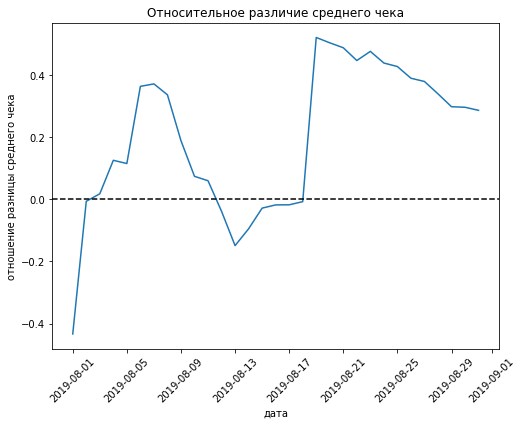

In [25]:
#график относительного различия для среднего чека
plt.figure(figsize=(8,6))
plt.plot(data['date'], 
         (data['revenue_b_cum']/data['orders_b_cum'])
         /
         (data['revenue_a_cum']/data['orders_a_cum'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное различие среднего чека')
plt.xlabel('дата')
plt.ylabel('отношение разницы среднего чека')
plt.xticks(rotation=45) 
plt.show()

Результаты теста значительно и резко поменялись в районе 8го и 20го числа - график различия между сегментами резко «скачет», это гоовроит о присутсвии очень крупных заказов.

In [26]:
# считаем кумулятивную конверсию
data['conversion_a'] = data['orders_a_cum']  / data['visitors_a_cum'] 
data['conversion_b'] = data['orders_b_cum']  / data['visitors_b_cum'] 


In [27]:
data.head()

,date,orders_a_per_date,revenue_a_per_date,orders_b_per_date,revenue_b_per_date,orders_a_cum,revenue_a_cum,orders_b_cum,revenue_b_cum,visitors_a_per_date,visitors_b_per_date,visitors_a_cum,visitors_b_cum,conversion_a,conversion_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713,0.031989,0.023843
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294,0.031390,0.030912
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803,0.035772,0.029950
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573,0.030055,0.026428
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280,0.029837,0.027134


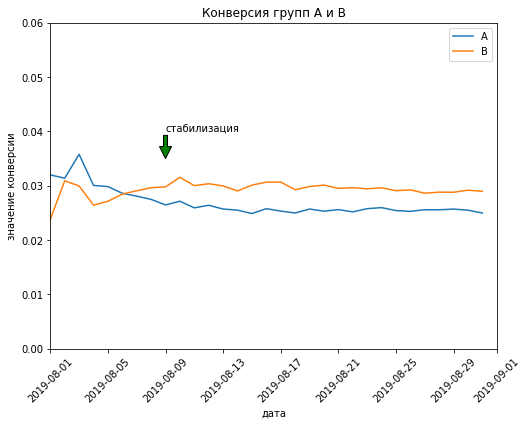

In [28]:
# строим графики
plt.figure(figsize=(8,6))
plt.plot(data['date'], data['conversion_a'], label='A')
plt.plot(data['date'], data['conversion_b'], label='B')

plt.annotate('стабилизация', xy=('2019-08-09', 0.035), xytext=('2019-08-09', 0.04),
            arrowprops=dict(facecolor='g'))  

plt.legend()
plt.title('Конверсия групп А и В')
plt.ylabel('значение конверсии')
plt.xlabel('дата')  
plt.axis(["2019-08-01", '2019-09-01', 0, 0.06]) 
plt.xticks(rotation=45)
plt.show()

С одной строны, конверсия менее подвержена колебанию, так как не имеет дела с суммой заказа, но она имеет дело с количеством заказов, где тоже могут быть аномалии. Тем не менее даже по данным спредположительными аномалиями можно сказать, что уже на 9ый день теста установлась стабильная тенденция: пользователи из группы В чаще становятся клиентами, чем пользователи из группы А. Мы изменили масштаб графика, чтобы было видно, что абсолютное колебание не слишком большое - в пределах 1%, при этом если смотеть вблизи (без изменения масшаба) будет казаться, что конверсии обоих групп еще колеблятся. 

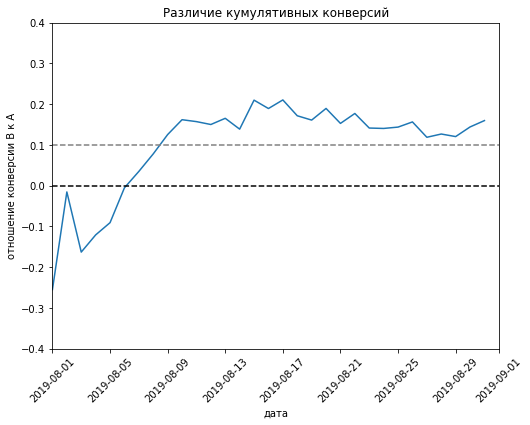

In [29]:
#график относительного различия кумулятивных конверсий
plt.figure(figsize=(8,6))
plt.plot(data['date'], (data['conversion_b']/data['conversion_a']-1),
         label="Относительный прирост конверсии группы B относительно группы A")



plt.title('Различие кумулятивных конверсий')
plt.ylabel('отношение конверсии В к А')
plt.xlabel('дата')

plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4]) 
plt.show()

Почти с самого начала теста группа В лидирует: сначала прирост был в районе 20%, потом слегка опустился и в последней рети месца держался на уровне 10%. Такие данные по конверсиям безусловно хороший знак, ведь это говорит о том, что нововедение, которое тестировалось на группе В положительно влиеяет на интернет-магазин, однако перед тем как делать выводы стоит посмотреть на влияние аномальных значений на данные. 

###  Определение аномалий

In [30]:
#подсчитаем количество заказов по пользователям
orders_by_users = (
    orders
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


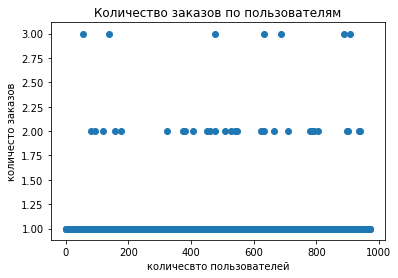

In [31]:
#построим точечный график количества заказов, передав ему
#ось х как числа от 0 до количесва всех заказов за испытумый период, ось y как количесвто заказов по пользователям

x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders']) 
plt.title('Количество заказов по пользователям')
plt.ylabel('количесто заказов')
plt.xlabel('количесвто пользователей')  
plt.show()


Точечный график иллюстрирует то, что большинсвто пользователей совершают 1 заказ, также довольно много тех, кто совершает 2 и относительно немного тех, кто совершает 3 заказа (как видно, это максимальное число заказов для нашей выборки). Однако точная доля тех, кто делает 3 заказа неясна — непонятно, считать их аномалиями или нет, поэтому посчитаем 90-й, 95-й и 99-й перцентили количества заказов.

In [32]:
print('Значения 90-го, 95-ого и 99-го перцентиля по количесву заказов на одного покупателя: ',
    np.percentile(orders_by_users['orders'], [90, 95, 99]))

Значения 90-го, 95-ого и 99-го перцентиля по количесву заказов на одного покупателя:  [1. 1. 2.]


Судя по вычислениям выходит, что у 95% пользователей 1 заказ, а у 99% - 1 или 2. То есть не более 1% пользователей совершали 3 4заказа. Возьмем за аномальное количесво заказов больше 2х - тогда в нашу "очищенную" выборку попадут 99% проценов всех покупателей. 

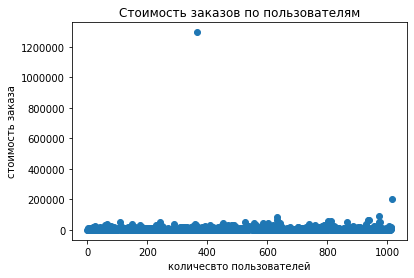

In [33]:
#построим точечный график стоимости заказов, передав ему
#в качесве оси х числа от 0 до количесва всех заказов за испытумый период, а в качесве оси y - значения выручки за каждый заказ

x_values2 = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values2, orders['revenue']) 

plt.title('Стоимость заказов по пользователям')
plt.ylabel('стоимость заказа')
plt.xlabel('количесвто пользователей')  
plt.show()


Основная масса заказов не превышает 20 000, однако есть и очень дорогой заказы, которые может влиять на наши результаты. Также есть еще заказ в районе 20 000, который тоже выбивается из общей массы.  По графику можно выбрать границу аномальных заказов выше например, 20 000,  однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. Определим 90, 95 и 99 перцентили стоимости заказа в выборке

In [34]:
print('Значения 90-го, 95-ого и 99-го перцентиля по стоимости заказов: ',
    np.percentile(orders['revenue'], [90, 95, 99]))

Значения 90-го, 95-ого и 99-го перцентиля по стоимости заказов:  [17990. 26785. 53904.]


Мы получили следующие значения: у 95% пользователей сумма заказа не выше примерно 18 000, а у 99% не выше 26800. То есть не более 1% пользователей совершали больше 4х заказов. Возьмем за аномальную стоимость все, что выше 26800,  так мы уберём примерно 5% пользователей с очень дорогими заказами. 

### Сравнение статистической значимости по сырым и отфильтрованным данным 

Итак, мы увидели выбросы и нашли границу для их определения.Теперь посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [35]:
#Создадим переменные для каждой группы, в которых укажем пользователей, которые заказывали хотя бы 1 раз или больше
orders_by_a = (
    orders.query("group == 'A'")
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_a.columns = ['visitor_id', 'orders']

#display(orders_by_a.head())


orders_by_b = (
    orders.query("group == 'B'")
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_b.columns = ['visitor_id', 'orders']
#orders_by_b.head()

Однако, стоит учесть тех пользователей, которые ничего не заказали, для этого добавим нужное количество 0 - оно равно разнице между суммой посетителей и количеством записей о заказах. Склеим вместе нужное количество нулей и данные по количесву заказов
В sample_а сохраним выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Логично, что число элементов это выборки — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке sample_а методом mean(). Аналогично посчитаем конверсию группы B. 

In [36]:
#pd.Series(0, index=np.arange(data['visitors_a_per_date'].sum() - len(orders_by_a['orders'])), name='orders')


sample_a = pd.concat([orders_by_a['orders'], 
    pd.Series(0, index=np.arange(data['visitors_a_per_date'].sum() - len(orders_by_a['orders'])), name='orders')                  
    ],axis=0)
#sample_a

sample_b = pd.concat([orders_by_b['orders'], 
    pd.Series(0, index=np.arange(data['visitors_b_per_date'].sum() - len(orders_by_b['orders'])), name='orders')                  
    ],axis=0)
#sample_b

Мы сформировали две выборки по данным теста - для группы А и для группы В. Теперь с помощью статистического теста мы можем проверить отличаются ли их распределения. Сформулируем гипотезы для проверки: 
- Нулевая гипотеза: распределение конверсии пользователей группы В не отличается от распределения конверсий пользователей группы А
- Альтернативная гипотеза: распределение конверсии пользователей группы В отличается от распределения конверсий пользователей группы А 

Стоит заметить, что все альтерантивные гипотезы, которые мы будем проверять в этом исследовнании относятся к двухстронним, то есть мы утверждаем, что две группы будут отличаться, при этом нас сайчас не интрересует в какую сторону, то есть в случае принятия альтернативной гипотезы мы будем знать лишь то, что группа В отличается от группы А. Однако именно этот тест не будет показывать, что некая величина в группе В, например, больше. Из этих будем указывать в тесте Манна-Уитни в качесве парметров не только полученые выборки, но и парамерт alternative='two-sided'.

In [37]:
alpha = 0.05 # критический уровень статистической значимости
alpha = alpha / 2 # так как мы будем проверять 2 гипотезы на одних и тех же данных разделим уровень значимости на 2 

print("{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b, alternative='two-sided')[1]))

if stats.mannwhitneyu(sample_a, sample_b, alternative='two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 
    
#выведем отнонешение средней конверсии группы В к конверсии группы А
print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.011
Отвергаем нулевую гипотезу: разница статистически значима
0.160


Первое число — p-value = 0.011 меньше выбранного нами критического уровня, а значит мы можем отвергать нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, то есть различия есть. И эти различия примерно равны 16%. Другими словами, на основании статистического теста Уилкоксона-Манна-Уитни мы можем утверждать, что нововведение, которое тестировалось на группе B действительно повысило конверсию 

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, просто передадим критерию mannwhitneyu() данные о выручке с заказов из таблицы orders. Также найдём относительные различия в среднем чеке между группами. Сформулируем гипотезы для проверки: 
- Нулевая гипотеза: распределение чеков пользователей группы В не отличается от распределения чеков пользователей группы А
- Альтернативная гипотеза: распределение чеков пользователей группы В отличается от распределения чеков пользователей группы А 

In [38]:
print('{0:.3f}'.format(
    stats.mannwhitneyu(orders.query("group == 'A'")['revenue'], 
                       orders.query("group == 'B'")['revenue'], 
                       alternative='two-sided')[1]))

if (stats.mannwhitneyu(orders.query("group == 'A'")['revenue'], 
                       orders.query("group == 'B'")['revenue'],
                           alternative='two-sided') [1]) < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

#выведем отнонешение среднего чека группы В к среднему чеку группы А
print('{0:.3f}'.format(orders.query("group == 'B'")['revenue'].mean()/orders.query("group == 'A'")['revenue'].mean()-1)) 

0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
0.287


P-value значительно больше альфа. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако простое сравнение средних говорит о том, что средний чек группы B значительно выше среднего чека группы - больше, чем на 29%. Очистим данные от аномалий и проведем эти тесты еще раз: уберем тех пользователей, котрые совершили больше 3х заказов и тех пользователей, чьи заказы дороже 28000. Для этого соберем всех пользователей с любыми аномалиями в однин массив 

In [39]:
users_with_many_оrders = pd.concat(
    [
        orders_by_a.query('orders > 2')['visitor_id'],
        orders_by_b.query('orders > 2')['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_оrders = orders.query('revenue > 26800')['visitor_id']

abnormal_users = (pd.concat([users_with_many_оrders, users_with_expensive_оrders ], axis=0)
                  .drop_duplicates()
                  .sort_values())

print('Процент аномальных пользователей: {:.1%}'
    .format(len(abnormal_users)/len(orders.groupby('visitor_id')['revenue'].sum())))



Процент аномальных пользователей: 6.0%


Для того, чтобы получить данные без аномалий нам нужно исключить из общей выборки 6% пользователей. Заметим, что мы исключаем именно пользователей целиком, а не заказы. Для того, чтобы узнать как их действия повлияли на результат, подготовим очищенные выборки 

In [40]:
sample_a_filtered = pd.concat([orders_by_a[np.logical_not(
    orders_by_a['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(
            0,
            index=np.arange(data['visitors_a_per_date'].sum() - len(orders_by_a['orders'])),
            name='orders')
            ],
    axis=0)


sample_b_filtered = pd.concat([orders_by_b[np.logical_not(
    orders_by_b['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series(
            0,
            index=np.arange(data['visitors_b_per_date'].sum() - len(orders_by_b['orders'])),
            name='orders')
            ],
    axis=0)

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным, снова применим тест Уилкоксона-Манна-Уитни. Будем опираться на уже сфрмулированные гипотезы с небольшим утчонением: 
- Нулевая гипотеза: распределение конверсии пользователей группы В по данным без аномалий не отличается от распределения конверсий пользователей группы А
- Альтернативная гипотеза: распределение конверсии пользователей группы В по данным без аномалийотличается от распределения конверсий пользователей группы А 

In [41]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative='two-sided')[1]))

if stats.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative='two-sided')[1] < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 


print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

0.012
Отвергаем нулевую гипотезу: разница статистически значима
0.182


Результат по очищенным данным почти такой же, как и по сырым: p-value все еще меньше критичесого уровня значимости, что снова говорит о том, что в группах есть статистическая разница. По сравнению средних, значение разницы конверсий выросло на 2%, что возможно объясняется тем, что в группе А у каких-то пользователе было аномально много заказов. 

То же самое сделаем и для результатов сренего чека. Слегка измеим гипотезы для проверки: 
- Нулевая гипотеза: распределение чеков пользователей группы В по данным без аномалий не отличается от распределения чеков пользователей группы А
- Альтернативная гипотеза: распределение чеков пользователей группы В по данным без аномалий отличается от распределения чеков пользователей группы А 

In [42]:
#посмотрим на результаты по среднему чеку 
print('{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
            
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
            alternative='two-sided'
        )[1]
    ))

#сравним значение p-value с критическим
if stats.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
            
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
            alternative='two-sided'
        )[1] < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 


#выведем отнонешение среднего чека группы В к среднему чеку группы А
print("{0:.3f}".format(
        orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
        / 
        orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1
    )) 

0.646
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
-0.048


На этот раз результат по очищенным данным не совсем такой как по сырым: хотя нулевую гипотезу так и не получилось отвергнуть, p-value слегка уменьшилось, а разница между группами значительно сократилась  (с 29% перевеса группы B на 5% перевеса группы А). Похоже, пики на графике относительного различия средних чеков образовались из-за очень больших заказов в группе В, а тот спад, что был в районе 13-го числа как раз и дает отрицательный результат

Стоит отдельно сказать о влиянии аномалий на результаты теста: общие выводы по результатам теста не изменились (статистическая значимость у разницы по конверсии есть, а по среденему чеку - нет), однако было видно, как сильно аномалии влияют на средний чек - убрав их, мы получили чуть ли не обратные результаты (хотя и не статисически значимые)

### Выводы 

1. Есть статистически значимое различие по конверсии между группами и по «сырым», и по «очищенным» данным;
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий - и хотя очищенные данные показывают небольшой перевес в сторону группы А, сложно делать определенные выводы по чеку на данном этапе, так как даже после удаления аномалий в данных не сало меньше шума
3. Различия кумулятивной конверсии между группами сообщает, что результаты группы B лучше, чем группы A и этот процесс подтвержден статистическим тестом (прирост коверсии около 14%)
4. На данном этапе стоит еще раз пересмотреть цели исследования. Если нам нужно было увеличить конверсию, то А/В тест можно признать успешным и зафиксировать победу группы В. Если цель была помимо конверсии увеличить средний чек, то исследование стоит продолжать, так как на основе только имеющихся данных мы не можем сделать вывода о влиянии нововведения на средний чек  

## Выводы по проекту

1. На первом этапе знакомства с данными была выявлена потенциальная ошибка в данных - около 5% пользователей попали однвременно в обе группы тестирования. Такие пользователи не должны попадать в данные для анализа.
2. Приоритезация гипотез показала, что для прилечения новых пользователей, стоит проверят гипотезу про сбор данных для email-рассылки или гипотезу про привлечение новых каналов трафика. Для повышение конверсии стоит обратить внимание на гипотезы о добавлении на сайт рекомендаций или баннеров с акциями
3. Обнаружено статистически значимое различие по конверсиям между группами А и В. Результаты группы B лучше, чем группы A  - прирост коверсии составляет около 14%, согласно сравнению кумулятивных конверсий.
4. На данном этапе исследования по среднему чеку между группами А и В не выявлено статистической разницы.
5. А/В тест можно признать успешным и зафиксировать победу группы В, если целью исследования был повышение конверсии. Нововведение, протестированное на группе В, можно применять на всех пользователях. 
6. Если цель исследование была так же в увеличении среднего чека, то пока нет оснований делать выводы о победе группы В. 